In [47]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from pygam import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
import random as random


In [2]:
# To see all columns
pd.set_option('display.max_columns', None)

# Importing and Cleaning Data

In [3]:
# Importing data
pitches_22 = pd.read_csv('updated_pitches_22_1.csv')
pitches_23 = pd.read_csv('updated_pitches_23_1.csv')
pitches_24 = pd.read_csv('updated_pitches_24_1.csv')

# Combine them
pitches_total = pd.concat([pitches_22, pitches_23, pitches_24])

In [4]:
# Organizing rows by game, at bat
pitches_total_sorted = pitches_total.sort_values(['gameid', 'ab', 'pitchnum']).reset_index(drop=True)

In [5]:
# Filtering out position pitchers pitching
# If a pitcher ever hit as well, they are likely a position player
# Will also use some more filtering to ensure Ohtani is included
pitchers = pitches_total_sorted['pitcher'].unique()  # pitcher column contains MLBAM IDs
batters = pitches_total_sorted['batter'].unique()

# Edge case for Ohtani, any other known pitcher that somehow hit
pitch_counts = pitches_total_sorted['pitcher'].value_counts()
valid_pitchers = set(pitch_counts[pitch_counts > 200].index)

pitches_total_sorted = pitches_total_sorted[(~pitches_total_sorted['pitcher'].isin(batters)) |
                                            (pitches_total_sorted['pitcher'].isin(valid_pitchers))].reset_index(drop=True)


In [6]:
# Remove any Statcast errors in release speed (may need to filter out more errors)
pitches_total_sorted = (pitches_total_sorted[(pitches_total_sorted['relspeed'] > 50) &
                                             (pitches_total_sorted['relspeed'] < 108)]).reset_index(drop=True)

We want to work with grounded into double play batted ball profiles, so let's filter for plays where there was a 
grounded into double play

# Finding Most Optimal GIDP Contact -- MULTIPLE TYPES

In [7]:
dps = pitches_total_sorted[pitches_total_sorted['eventtype'] == 'grounded_into_double_play']
# We have ~10,000 instances of GIDP, so we can work with this

In [8]:
# 10,005 grounded into double plays instances
len(dps)

10005

<Axes: xlabel='ExitSpeed', ylabel='Density'>

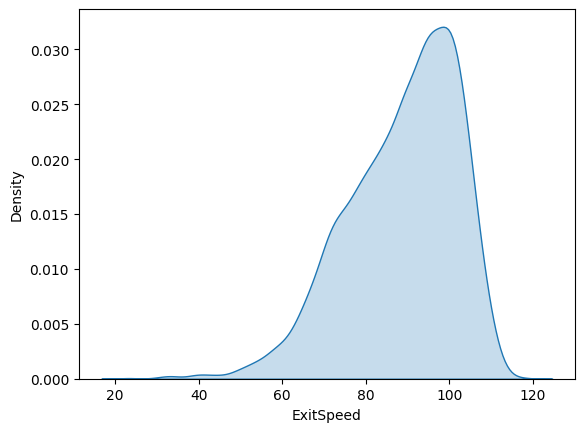

In [9]:
# GIDP batted ball profile distributions 
sns.kdeplot(dps['ExitSpeed'], fill=True)

In [10]:
np.mean(dps['ExitSpeed']), np.nanmedian(dps['ExitSpeed'])

(np.float64(88.63305389825408), np.float64(90.858215))

<Axes: xlabel='ExitSpeed', ylabel='Density'>

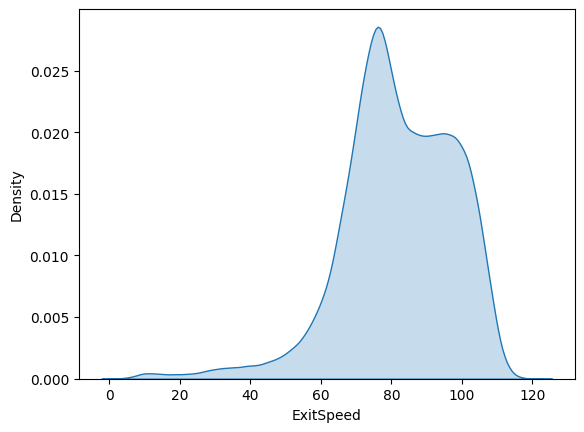

In [11]:
sns.kdeplot(pitches_total_sorted['ExitSpeed'], fill=True)

<Axes: xlabel='VExitAngle', ylabel='Density'>

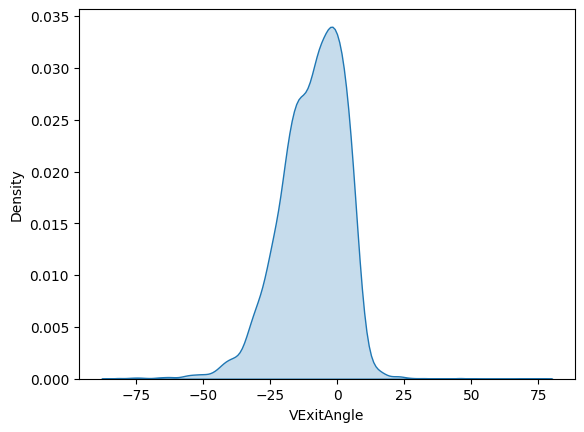

In [12]:
sns.kdeplot(dps['VExitAngle'], fill=True)

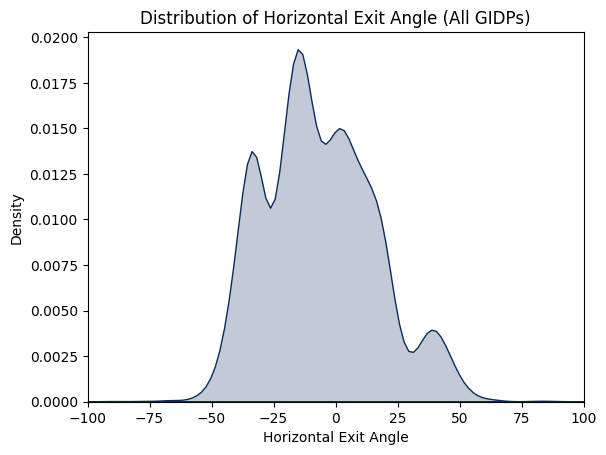

In [78]:
plt.figure()
sns.kdeplot(dps['HExitAngle'], fill=True, color="#092C5C")
plt.title("Distribution of Horizontal Exit Angle (All GIDPs)")
plt.xlabel("Horizontal Exit Angle")
plt.xlim(-100, 100)
plt.show()

<Axes: xlabel='HExitAngle', ylabel='Density'>

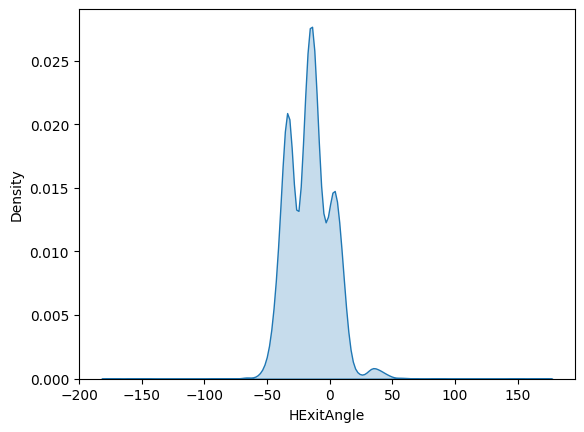

In [14]:
# Right handed hitters HExitAngle
sns.kdeplot(dps[dps['batterside'] == 'R']['HExitAngle'], fill=True)


<Axes: xlabel='HExitAngle', ylabel='Density'>

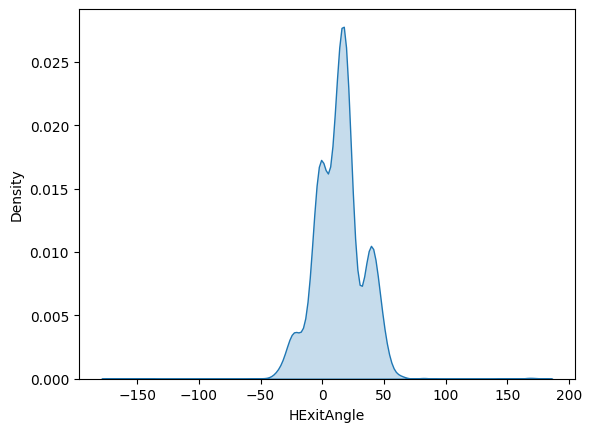

In [15]:
sns.kdeplot(dps[dps['batterside'] == 'L']['HExitAngle'], fill=True)

## Right-handed Hitters Optimal GIDP Contact

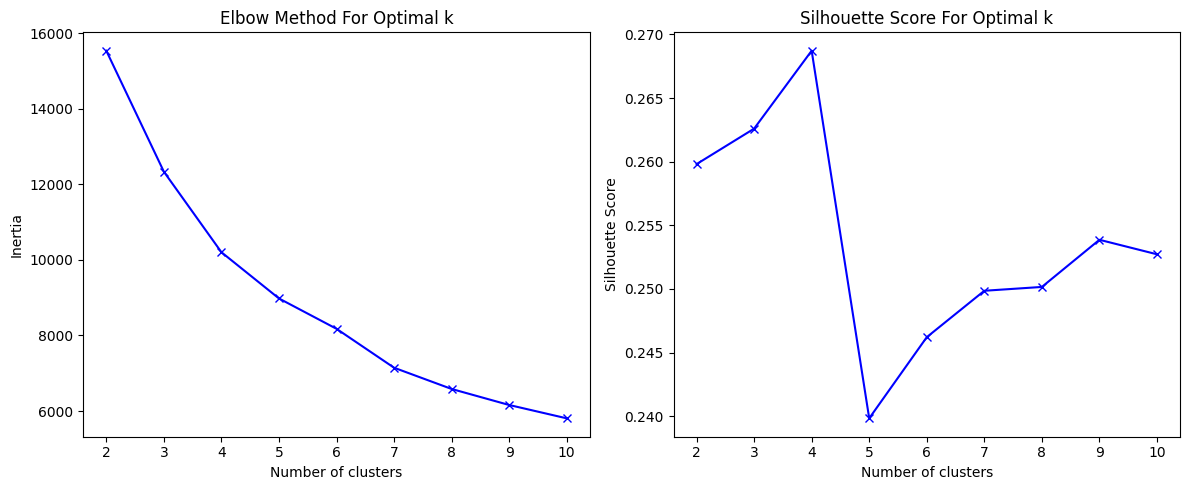

In [18]:
X_right = dps[dps['batterside'] == 'R'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()

# Scale data
scaler_right = StandardScaler()
X_right_scaled = scaler_right.fit_transform(X_right)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_right_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_right_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

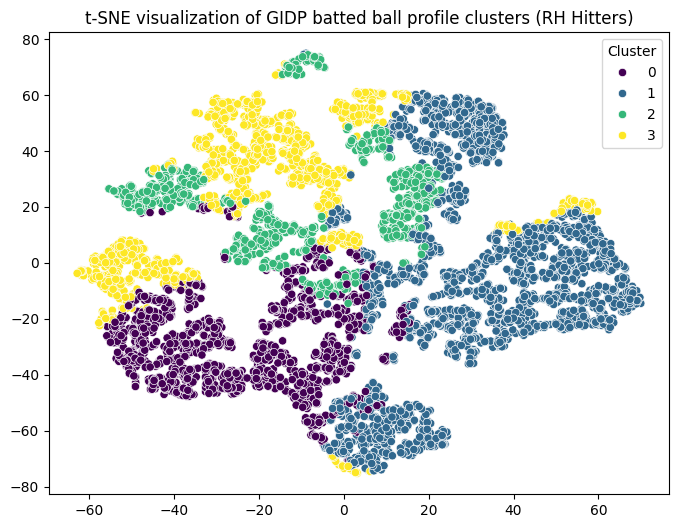

In [19]:
k = 4
kmeans_right = KMeans(n_clusters=k, n_init=50, random_state=42)
X_right['Cluster'] = kmeans_right.fit_predict(X_right_scaled)

tsne_right = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_right = tsne_right.fit_transform(X_right_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_right[:, 0], y=X_tsne_right[:, 1], hue=X_right['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (RH Hitters)')
plt.show()

## Left-handed Hitters Optimal GIDP Contact

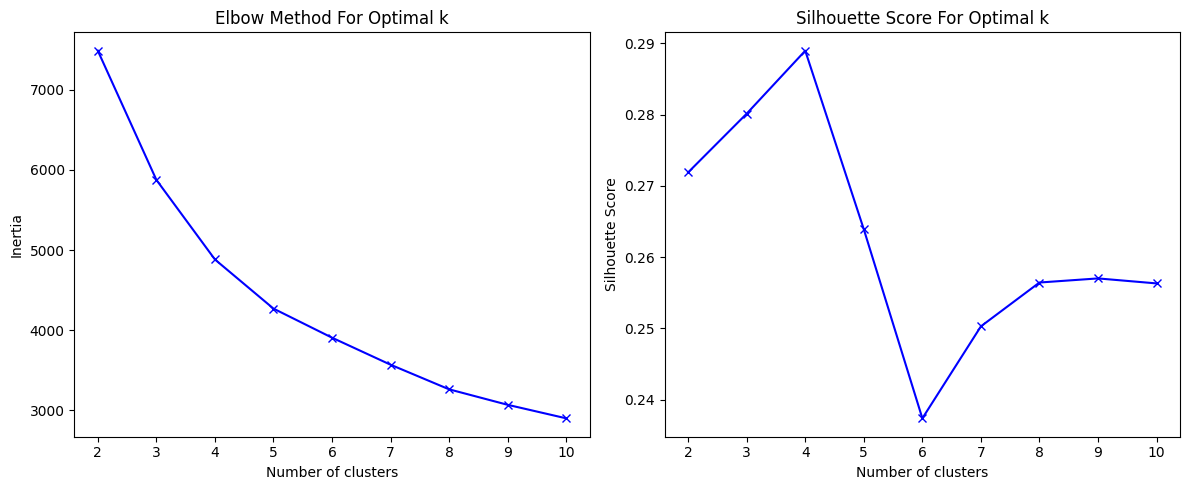

In [20]:
X_left = dps[dps['batterside'] == 'L'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Determine optimal number of clusters using the elbow method and silhouette score
# Scale data
scaler_left = StandardScaler()
X_left_scaled = scaler_left.fit_transform(X_left)
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_left_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_left_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

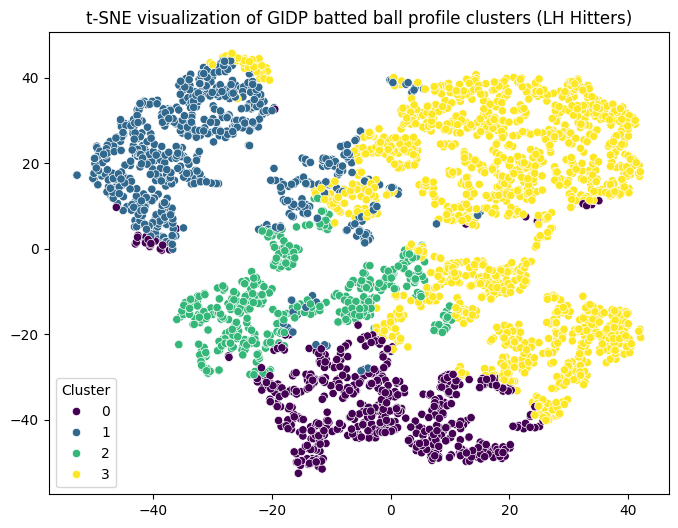

In [21]:
# K is 5 
k = 4
kmeans_left = KMeans(n_clusters=k, n_init=50, random_state=42)
X_left['Cluster'] = kmeans_left.fit_predict(X_left_scaled)

tsne_left = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_left = tsne_right.fit_transform(X_left_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_left[:, 0], y=X_tsne_left[:, 1], hue=X_left['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (LH Hitters)')
plt.show()

## Overall KMeans (all hitters)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

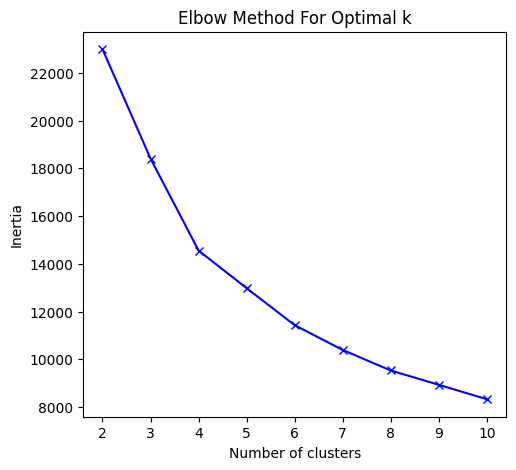

In [22]:
# KMeans to find GIDP batted ball profile clusters
# Using exit speed, vertical exit angle, horizontal exit angle
X = dps[['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

In [23]:
k = 5
kmeans_overall = KMeans(n_clusters=k, n_init=50, random_state=42)
X['Cluster'] = kmeans_overall.fit_predict(X_scaled)

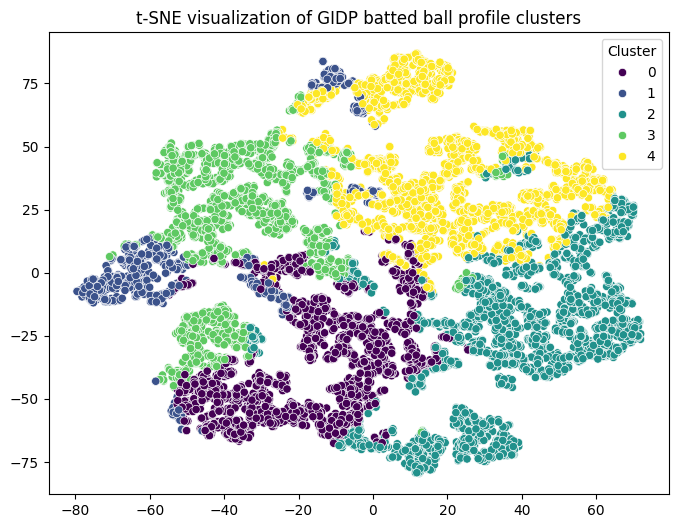

In [24]:
# Plotting with the clusters with tSNE

tsne = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters')
plt.show()

## Exploring Each Cluster

In [25]:
# Right-handed clusters

RHH_cluster_0 = X_right[X_right['Cluster'] == 0]
RHH_cluster_1 = X_right[X_right['Cluster'] == 1]
RHH_cluster_2 = X_right[X_right['Cluster'] == 2]
RHH_cluster_3 = X_right[X_right['Cluster'] == 3]


# Left-handed clusters
LHH_cluster_0 = X_left[X_left['Cluster'] == 0]
LHH_cluster_1 = X_left[X_left['Cluster'] == 1]
LHH_cluster_2 = X_left[X_left['Cluster'] == 2]
LHH_cluster_3 = X_left[X_left['Cluster'] == 3]

# Cluster summaries for RHH
for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    print(f"RHH Cluster {i}:")
    print(cluster.describe())
    print("\n")

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    print(f"LHH Cluster {j}:")
    print(cluster.describe())
    print("\n")

RHH Cluster 0:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  1552.000000  1552.000000  1552.000000   1552.0
mean     86.121655   -18.881657   -33.721516      0.0
std      10.401094     9.088373    10.760939      0.0
min      44.046710   -82.071480  -173.132600      0.0
25%      79.617230   -24.128577   -39.849818      0.0
50%      87.402610   -17.829730   -34.298575      0.0
75%      93.405385   -12.593958   -26.808160      0.0
max     110.140400     1.745070   -13.458490      0.0


RHH Cluster 1:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  2677.000000  2677.000000  2677.000000   2677.0
mean     99.365633    -4.850142   -14.181080      1.0
std       5.747214     7.011172    12.890473      0.0
min      85.199830   -26.713250   -42.847060      1.0
25%      95.161410    -9.686825   -21.125510      1.0
50%      99.600560    -4.070016   -14.615790      1.0
75%     103.482600     0.582191    -7.606992      1.0
max     118.319200     9.480888    33.365910      

### Visualizations of Clusters

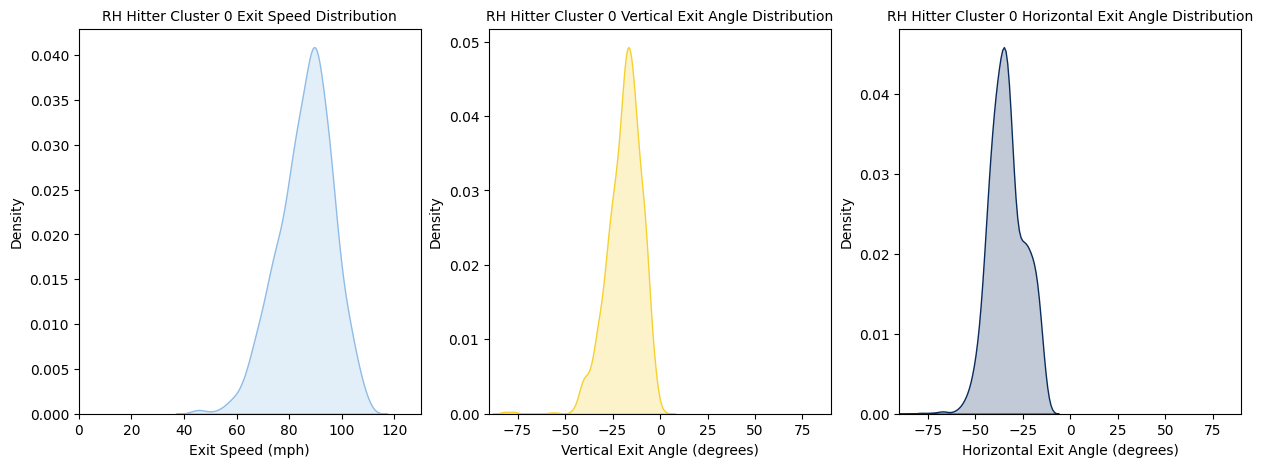

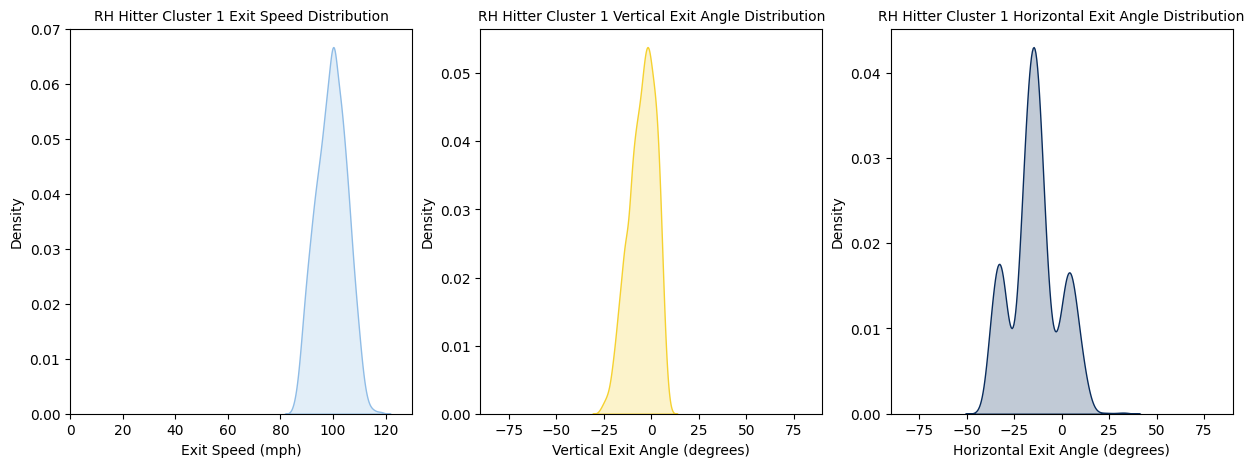

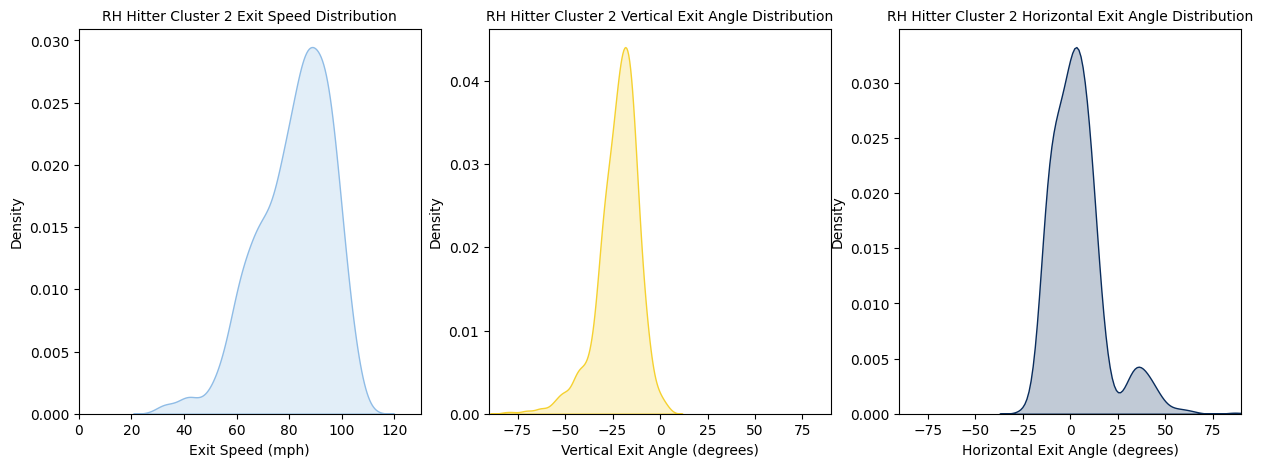

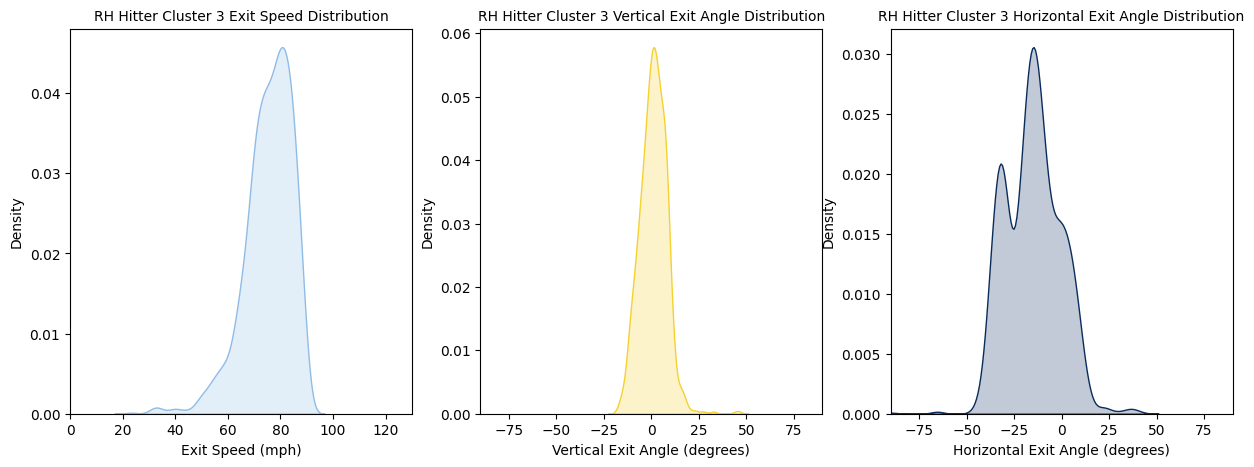

In [26]:
# Plotting densities for each cluster RHH

for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3,  1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'RH Hitter Cluster {i} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'RH Hitter Cluster {i} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'RH Hitter Cluster {i} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

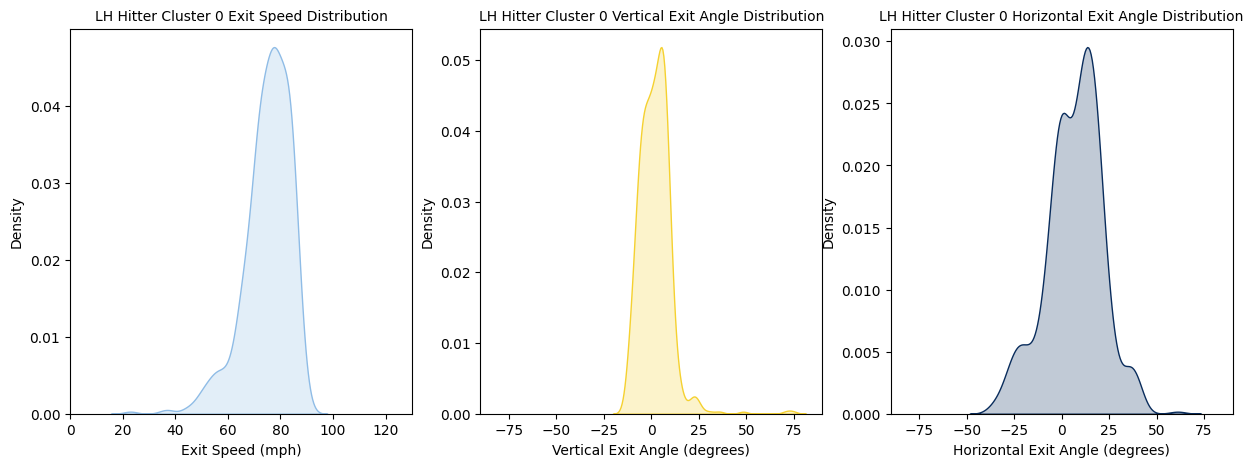

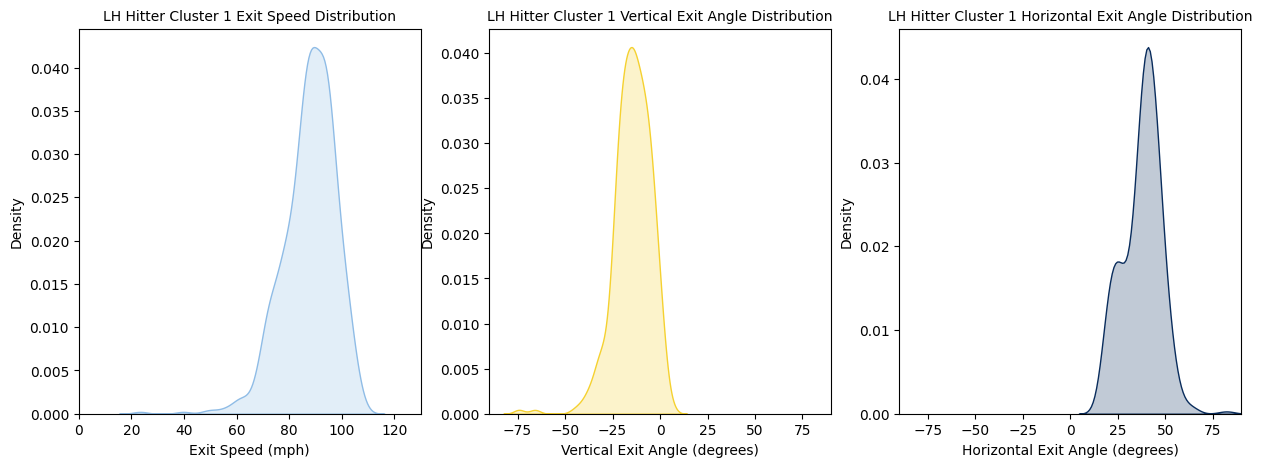

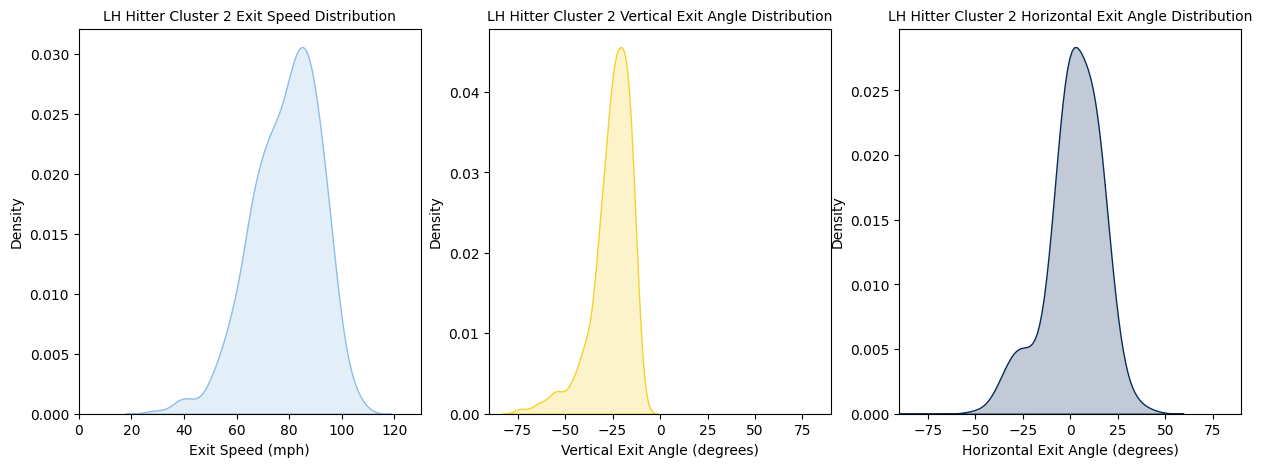

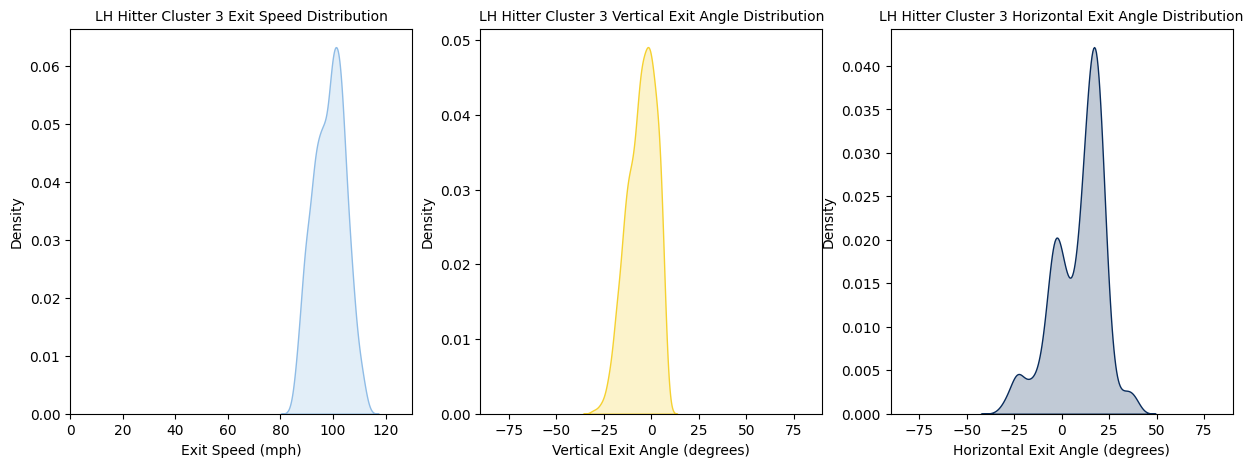

In [27]:
# Plotting densities for each cluster (LHH)

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'LH Hitter Cluster {j} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'LH Hitter Cluster {j} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'LH Hitter Cluster {j} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

In [28]:
# Converting right, left handed dataframes to CSVs for export
X_right.to_csv('RHH_GIDP_ByCluster.csv', index=False)
X_left.to_csv('LHH_GIDP_ByCluster.csv', index=False)

In [29]:
# Cluster Centers for Right, Left, Overall
print("RHH Cluster Centers:")
print(scaler_right.inverse_transform(kmeans_right.cluster_centers_))
print("\nLHH Cluster Centers:")
print(scaler_left.inverse_transform(kmeans_left.cluster_centers_))
print("\nOverall Cluster Centers:")
print(scaler.inverse_transform(kmeans_overall.cluster_centers_))

RHH Cluster Centers:
[[ 86.16527538 -18.82063588 -33.7145816 ]
 [ 99.37294918  -4.84541348 -14.13193427]
 [ 81.78293892 -22.23231858   4.08686438]
 [ 75.34863586   1.01234285 -15.18619346]]

LHH Cluster Centers:
[[ 74.93667019   1.94308248   6.66476166]
 [ 87.59216297 -14.60284926  38.37646882]
 [ 78.73517857 -25.5285728    0.99526452]
 [ 98.55103375  -5.14815172   8.99503865]]

Overall Cluster Centers:
[[ 88.97244423 -20.48261348 -24.99704906]
 [ 69.91975799 -28.62909125   9.48391388]
 [ 98.74720178  -2.95492216 -17.61532258]
 [ 74.10530341   0.61437865 -10.29987164]
 [ 94.80783927  -8.51540138  19.04951883]]


## Given the Cluster Centers, Find Sweet Spot:

In [30]:
# Middle 80% of All 3 Variables as Sweet Spot for each GIDP Profile
# RIGHT HANDED
# Cluster 0
mid_50_right_0_ev = np.percentile(RHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_right_0_vla = np.percentile(RHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_right_0_hla = np.percentile(RHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_0 = [mid_50_right_0_ev, mid_50_right_0_vla, mid_50_right_0_hla]
# Cluster 1
mid_50_right_1_ev = np.percentile(RHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_right_1_vla = np.percentile(RHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_right_1_hla = np.percentile(RHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_1 = [mid_50_right_1_ev, mid_50_right_1_vla, mid_50_right_1_hla]
# Cluster 2
mid_50_right_2_ev = np.percentile(RHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_right_2_vla = np.percentile(RHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_right_2_hla = np.percentile(RHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_2 = [mid_50_right_2_ev, mid_50_right_2_vla, mid_50_right_2_hla]
# Cluster 3
mid_50_right_3_ev = np.percentile(RHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_right_3_vla = np.percentile(RHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_right_3_hla = np.percentile(RHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_3 = [mid_50_right_3_ev, mid_50_right_3_vla, mid_50_right_3_hla]

# LEFT HANDED
# Cluster 0
mid_50_left_0_ev = np.percentile(LHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_left_0_vla = np.percentile(LHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_left_0_hla = np.percentile(LHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_0 = [mid_50_left_0_ev, mid_50_left_0_vla, mid_50_left_0_hla]
# Cluster 1
mid_50_left_1_ev = np.percentile(LHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_left_1_vla = np.percentile(LHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_left_1_hla = np.percentile(LHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_1 = [mid_50_left_1_ev, mid_50_left_1_vla, mid_50_left_1_hla]
# Cluster 2
mid_50_left_2_ev = np.percentile(LHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_left_2_vla = np.percentile(LHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_left_2_hla = np.percentile(LHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_2 = [mid_50_left_2_ev, mid_50_left_2_vla, mid_50_left_2_hla]
# Cluster 3
mid_50_left_3_ev = np.percentile(LHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_left_3_vla = np.percentile(LHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_left_3_hla = np.percentile(LHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_3 = [mid_50_left_3_ev, mid_50_left_3_vla, mid_50_left_3_hla]

rhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_right_0,
    'Cluster 1': sweet_spot_right_1,
    'Cluster 2': sweet_spot_right_2,
    'Cluster 3': sweet_spot_right_3
}

lhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_left_0,
    'Cluster 1': sweet_spot_left_1,
    'Cluster 2': sweet_spot_left_2,
    'Cluster 3': sweet_spot_left_3

}

print("RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in rhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")
print("\nLHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in lhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")

RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [71.826478 98.486125], Vertical Launch Angle [-30.646302   -8.1809735], Horizontal Launch Angle [-44.439125 -20.10135 ]
Cluster 1: Exit Speed [ 91.503252 106.80714 ], Vertical Launch Angle [-14.640746    3.7866784], Horizontal Launch Angle [-32.734876    4.7644908]
Cluster 2: Exit Speed [62.477488 97.839976], Vertical Launch Angle [-35.043813 -10.72497 ], Horizontal Launch Angle [-11.608352  17.402104]
Cluster 3: Exit Speed [64.135324 85.613944], Vertical Launch Angle [-8.1400314  8.8388861], Horizontal Launch Angle [-33.968526    3.8510228]

LHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [64.363912 84.463644], Vertical Launch Angle [-7.4345796  9.7012342], Horizontal Launch Angle [-12.381022  22.618822]
Cluster 1: Exit Speed [74.236672 99.226006], Vertical Launch Angle [-25.482006   -3.1901688], Horizontal Launch Angle [22.672844 49.00901 ]
Cluster 2: Exit Speed [62.2861   94.189

## Trying out a different range for Sweet Spot

In [31]:
# Middle 60% of All 3 Variables as Sweet Spot for each GIDP Profile
# RIGHT HANDED
# Cluster 0
mid_50_right_0_ev_60 = np.percentile(RHH_cluster_0['ExitSpeed'], [20, 80], axis=0)
mid_50_right_0_vla_60 = np.percentile(RHH_cluster_0['VExitAngle'], [20, 80], axis=0)
mid_50_right_0_hla_60 = np.percentile(RHH_cluster_0['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_0_60 = [mid_50_right_0_ev_60, mid_50_right_0_vla_60, mid_50_right_0_hla_60]
# Cluster 1
mid_50_right_1_ev_60 = np.percentile(RHH_cluster_1['ExitSpeed'], [20, 80], axis=0)
mid_50_right_1_vla_60 = np.percentile(RHH_cluster_1['VExitAngle'], [20, 80], axis=0)
mid_50_right_1_hla_60 = np.percentile(RHH_cluster_1['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_1_60 = [mid_50_right_1_ev_60, mid_50_right_1_vla_60, mid_50_right_1_hla_60]
# Cluster 2
mid_50_right_2_ev_60 = np.percentile(RHH_cluster_2['ExitSpeed'], [20, 80], axis=0)
mid_50_right_2_vla_60 = np.percentile(RHH_cluster_2['VExitAngle'], [20, 80], axis=0)
mid_50_right_2_hla_60 = np.percentile(RHH_cluster_2['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_2_60 = [mid_50_right_2_ev_60, mid_50_right_2_vla_60, mid_50_right_2_hla_60]
# Cluster 3
mid_50_right_3_ev_60 = np.percentile(RHH_cluster_3['ExitSpeed'], [20, 80], axis=0)
mid_50_right_3_vla_60 = np.percentile(RHH_cluster_3['VExitAngle'], [20, 80], axis=0)
mid_50_right_3_hla_60 = np.percentile(RHH_cluster_3['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_3_60 = [mid_50_right_3_ev_60, mid_50_right_3_vla_60, mid_50_right_3_hla_60]

# LEFT HANDED
# Cluster 0
mid_50_left_0_ev_60 = np.percentile(LHH_cluster_0['ExitSpeed'], [20, 80], axis=0)
mid_50_left_0_vla_60 = np.percentile(LHH_cluster_0['VExitAngle'], [20, 80], axis=0)
mid_50_left_0_hla_60 = np.percentile(LHH_cluster_0['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_0_60 = [mid_50_left_0_ev_60, mid_50_left_0_vla_60, mid_50_left_0_hla_60]
# Cluster 1
mid_50_left_1_ev_60 = np.percentile(LHH_cluster_1['ExitSpeed'], [20, 80], axis=0)
mid_50_left_1_vla_60 = np.percentile(LHH_cluster_1['VExitAngle'], [20, 80], axis=0)
mid_50_left_1_hla_60 = np.percentile(LHH_cluster_1['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA
sweet_spot_left_1_60 = [mid_50_left_1_ev_60, mid_50_left_1_vla_60, mid_50_left_1_hla_60]
# Cluster 2
mid_50_left_2_ev_60 = np.percentile(LHH_cluster_2['ExitSpeed'], [20, 80], axis=0)
mid_50_left_2_vla_60 = np.percentile(LHH_cluster_2['VExitAngle'], [20, 80], axis=0)
mid_50_left_2_hla_60 = np.percentile(LHH_cluster_2['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_2_60 = [mid_50_left_2_ev_60, mid_50_left_2_vla_60, mid_50_left_2_hla_60]
# Cluster 3
mid_50_left_3_ev_60 = np.percentile(LHH_cluster_3['ExitSpeed'], [20, 80], axis=0)
mid_50_left_3_vla_60 = np.percentile(LHH_cluster_3['VExitAngle'], [20, 80], axis=0)
mid_50_left_3_hla_60 = np.percentile(LHH_cluster_3['HExitAngle'], [20, 80], axis=0)
# [EV, VLA, HLA
sweet_spot_left_3_60 = [mid_50_left_3_ev_60, mid_50_left_3_vla_60, mid_50_left_3_hla_60]

rhh_GIDP_sweet_spots_60 = {
    'Cluster 0': sweet_spot_right_0_60,
    'Cluster 1': sweet_spot_right_1_60,
    'Cluster 2': sweet_spot_right_2_60,
    'Cluster 3': sweet_spot_right_3_60
}

lhh_GIDP_sweet_spots_60 = {
    'Cluster 0': sweet_spot_left_0_60,
    'Cluster 1': sweet_spot_left_1_60,
    'Cluster 2': sweet_spot_left_2_60,
    'Cluster 3': sweet_spot_left_3_60

}

print("RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in rhh_GIDP_sweet_spots_60.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")
print("\nLHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in lhh_GIDP_sweet_spots_60.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")

RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [77.595734 94.84602 ], Vertical Launch Angle [-25.812972 -11.47373 ], Horizontal Launch Angle [-41.108828 -24.69967 ]
Cluster 1: Exit Speed [ 94.131614 104.41874 ], Vertical Launch Angle [-10.995118   1.627282], Horizontal Launch Angle [-24.827552   -1.7375064]
Cluster 2: Exit Speed [69.470414 94.244222], Vertical Launch Angle [-29.443694 -13.941238], Horizontal Launch Angle [-7.9568682 10.896542 ]
Cluster 3: Exit Speed [68.943668 83.305482], Vertical Launch Angle [-4.788069  6.768949], Horizontal Launch Angle [-29.916894   -2.2496028]

LHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [69.016038 82.728594], Vertical Launch Angle [-4.9998764  7.2691126], Horizontal Launch Angle [-3.7675238 17.915702 ]
Cluster 1: Exit Speed [79.804486 95.809082], Vertical Launch Angle [-21.622896   -6.2695866], Horizontal Launch Angle [27.791024 45.607442]
Cluster 2: Exit Speed [67.405946 89.640162], 

# Feature Engineering Sweet-Spots on the entire dataset

We are just going to create a binary classifier problem (at least for now). 

We can always create a multi-class problem to determine whicn types of GIDP each pitch type induces the most.

In [32]:
# First, filter the main dataset to just balls put into play
bip_df = pitches_total_sorted[pitches_total_sorted['pitchresult_desc'].isin(
    ['Hit Into Play - Out(s)', 'Hit Into Play - Run(s)', 'Hit Into Play - No Out(s)'])
 ].copy()

In [33]:
# Apply a function to determine if each batted ball falls within any of the sweet spots

def is_in_sweet_spot(row, sweet_spots_right=rhh_GIDP_sweet_spots, 
                     sweet_spots_left=lhh_GIDP_sweet_spots, **kwargs):
    '''
    Determines if a batted ball falls within any of the defined sweet spots
    for right-handed or left-handed hitters based on exit velocity, vertical launch angle,
    and horizontal launch angle. This essentially captures whether a batted ball
    has the characteristics of a typical GIDP batted ball profile (many types).

    Params:
    row: A row from the DataFrame
    Returns:
    bool: True if the batted ball falls within any sweet spot, False otherwise
    '''
    ev = row['ExitSpeed']
    vla = row['VExitAngle']
    hla = row['HExitAngle']
    if row['batterside'] == 'R':

        for cluster, ranges in sweet_spots_right.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
            
    elif row['batterside'] == 'L':
        for cluster, ranges in sweet_spots_left.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
    return 0



In [35]:
# Apply the function to create a new column 'GIDP_SweetSpot'
bip_df['GIDP_SweetSpot'] = bip_df.apply(is_in_sweet_spot, axis=1)

In [39]:
bip_df['GIDP_SweetSpot_60'] = bip_df.apply(
    lambda row: is_in_sweet_spot(
        row,
        sweet_spots_right=rhh_GIDP_sweet_spots_60,
        sweet_spots_left=lhh_GIDP_sweet_spots_60
    ),
    axis=1
)


In [42]:
len(bip_df[bip_df['GIDP_SweetSpot_60'] == 1]) / len(bip_df)

0.056319647975237475

In [41]:
len(bip_df[bip_df['GIDP_SweetSpot'] == 1]) / len(bip_df)

0.15990487566159678

In [43]:
yesses = bip_df[bip_df['GIDP_SweetSpot'] == 1].copy()
yesses_2 = bip_df[bip_df['GIDP_SweetSpot_60'] == 1].copy()

In [44]:
bip_df_in_common = yesses_2.merge(
    dps[["gameid", "ab"]],
    on=["gameid", "ab"],
    how="inner"
)


In [45]:
bip_df_in_common

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot,GIDP_SweetSpot_60
0,2022/04/07/houmlb-anamlb-1,38:00.0,8,4,1,1,2,1,1,0,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2096.595,92.90878,-11.515430,5.122625,-26.445160,0.637365,1.679411,80.24135,-25.792980,-26.002420,0.990,50,5.847,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1,1
1,2022/04/08/balmlb-tbamlb-1,10:00.0,32,1,4,0,0,0,1,0,1,"McClanahan, Shane",L,"Chirinos, Robinson",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,CU,Curveball,2671.259,82.46291,6.973741,-9.690929,-49.819630,0.163417,1.648723,88.39170,-13.915420,-26.869260,0.859,50,5.951,139,Tampa Bay Rays,110,Baltimore Orioles,12,Tropicana Field,https://sporty-clips.mlb.com/cU5MOWdfWGw0TUFRP...,1,1
2,2022/04/08/miamlb-sfnmlb-1,35:00.0,43,3,6,0,0,2,0,0,3,"Webb, Logan",R,"Sanchez, Jesus",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,CH,Changeup,1448.600,86.51381,5.874516,-4.607069,-40.996660,-0.442779,1.579373,94.23468,-1.521019,3.846387,-1.364,50,5.079,137,San Francisco Giants,146,Miami Marlins,2395,Oracle Park,https://sporty-clips.mlb.com/ZXo3QXFfWGw0TUFRP...,1,1
3,2022/04/09/clemlb-kcamlb-1,10:00.0,63,3,9,1,2,0,1,0,0,"Gose, Anthony",L,"O'Hearn, Ryan",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2245.615,96.39956,-5.532959,15.855090,-13.581310,0.656107,2.457921,94.23934,-8.938514,44.909700,0.884,50,5.499,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/eTE2dllfWGw0TUFRP...,1,1
4,2022/04/10/cinmlb-atlmlb-1,35:00.0,74,2,9,1,1,0,0,6,3,"Warren, Art",R,"Dickerson, Alex",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2373.042,98.02368,0.787922,18.842670,-9.665148,0.156632,3.060824,81.49873,-0.812878,8.539303,-1.990,50,5.585,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/OE9ZOVlfWGw0TUFRP...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,2024/09/28/texmlb-anamlb-1,38:00.0,35,1,4,0,0,0,0,1,7,"Canning, Griffin",R,"Kelly, Carson",R,E,Hit Into Play - Run(s),grounded_into_double_play,Stretch,SL,Slider,2890.176,87.29869,-1.608167,0.296153,-35.597920,0.335488,1.943432,100.32000,-5.961649,-15.765940,-1.202,50,5.957,108,Los Angeles Angels,140,Texas Rangers,1,Angel Stadium,https://sporty-clips.mlb.com/eFoxQWtfWGw0TUFRP...,1,1
1906,2024/09/29/kcamlb-atlmlb-1,20:00.0,6,1,1,0,0,0,1,3,0,"Morton, Charlie",R,"Renfroe, Hunter",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,1890.540,94.58666,14.445540,1.470955,-29.242320,0.449284,2.528353,98.54160,-8.934601,-21.656720,-2.416,50,5.455,144,Atlanta Braves,118,Kansas City Royals,4705,Truist Park,https://sporty-clips.mlb.com/VmcweVBfWGw0TUFRP...,1,1
1907,2024/09/29/phimlb-wasmlb-1,05:00.0,64,1,8,0,0,0,1,6,3,"Rutledge, Jackson",R,"Sosa, Edmundo",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2271.258,94.80019,17.630950,8.830441,-21.556580,-0.008662,2.428013,102.96830,-1.591202,-12.751160,-2.081,50,5.864,120,Washington Nationals,143,Philadelphia Phillies,3309,Nationals Park,https://sporty-clips.mlb.com/OVpLTUFfWGw0TUFRP...,1,1
1908,2024/09/29/tbamlb-bosmlb-1,05:00.0,43,1,5,1,0,0,1,1,3,"Montgomery, Mason",L,"Abreu, Wilyer",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2229.874,97.55892,-6.959518,18.442280,-10.

In [39]:
print(bip_df[["ExitSpeed", "VExitAngle", "HExitAngle", "batterside"]].head())


    ExitSpeed  VExitAngle  HExitAngle batterside
10   55.31276  -42.227200   -0.448136          R
19   91.72955   -0.069351   12.199050          R
21  100.97140   36.611920  -17.393650          R
31   98.19635    8.123025   -3.759704          R
34   69.13850   64.647930   -1.996992          L


Now that we have GIDP clusters, find sweet spots for each metric. But they are all dependent of eachother, so need to figure this out.

In [40]:
# Saving clusters to CSV
X_right.to_csv('RHH_GIDP_Clusters.csv', index=False)
X_left.to_csv('LHH_GIDP_Clusters.csv', index=False)

# Feature Engineering Different Pitch Archetypes -- "Curveball" is too general. Changeup low and away is MUCH different from changeups up and away. 

7286 games between '22 and '24

## Modeling

In [53]:
# Drop NA values for modeling
bip_df = bip_df.dropna()

### Utilizing a GAM

Going to create 4 different models depending on platoons: RHP v RHH, RHP v LHH, LHP v RHH, LHP v LHH

In [54]:
# Create four different subsets based on pitcher-batter handedness
RHP_RHH = bip_df[(bip_df['pitcherthrows'] == 'R') & (bip_df['batterside'] == 'R')]
RHP_LHH = bip_df[(bip_df['pitcherthrows'] == 'R') & (bip_df['batterside'] == 'L')]
LHP_RHH = bip_df[(bip_df['pitcherthrows'] == 'L') & (bip_df['batterside'] ==  'R')]
LHP_LHH = bip_df[(bip_df['pitcherthrows'] == 'L') & (bip_df['batterside'] == 'L')]

In [124]:
# Export to csvs
RHP_RHH.to_csv('RHP_RHH_BIP.csv', index=False)
RHP_LHH.to_csv('RHP_LHH_BIP.csv', index=False)
LHP_RHH.to_csv('LHP_RHH_BIP.csv', index=False)
LHP_LHH.to_csv('LHP_LHH_BIP.csv', index=False)

In [52]:
def create_zone_heatmap(gam, X_train, title_str='RHH v RHP'):
    '''
    Creates a heatmap to visualize the effect of plate location (side and height)
    on the probability of a GIDP occurring, based on the fitted GAM model.

    Params:
    gam_RR: Fitted LogisticGAM model
    X_train: Training feature set used for the model
    '''
    zone_idx = 3
    x_range = np.linspace(X_train[:, 5].min(), X_train[:, 5].max(), 50)  # plate side
    z_range = np.linspace(X_train[:, 6].min(), X_train[:, 6].max(), 50)  # plate height
    XX, ZZ = np.meshgrid(x_range, z_range)
    pdep = gam.partial_dependence(term=zone_idx, X=(XX, ZZ), meshgrid=True)
    plt.figure(figsize=(6, 5))
    plt.contourf(XX, ZZ, pdep, levels=30, cmap="coolwarm")
    plt.colorbar(label="Partial Effect (log-odds)")
    plt.xlabel("Plate Side (ft)")
    plt.ylabel("Plate Height (ft)")
    plt.title(f"{title_str} Effect of Plate Location on GIDP Probability")
    plt.show()


In [52]:
pred_probs_RR = gam_RR.predict_proba(X_test_RR)
pred_class_RR = gam_RR.predict(X_test_RR)

print("AUC:", roc_auc_score(y_test_RR, pred_probs_RR))
print("Accuracy:", accuracy_score(y_test_RR, pred_class_RR))

AUC: 0.6265338030438271
Accuracy: 0.8299613313078305


## RHP v LHH

In [55]:
pred_probs_RL = gam_RL.predict_proba(X_test_RL)
pred_class_RL = gam_RL.predict(X_test_RL)

print("AUC:", roc_auc_score(y_test_RL, pred_probs_RL))
print("Accuracy:", accuracy_score(y_test_RL, pred_class_RL))

AUC: 0.6318197545556534
Accuracy: 0.8496091376726478


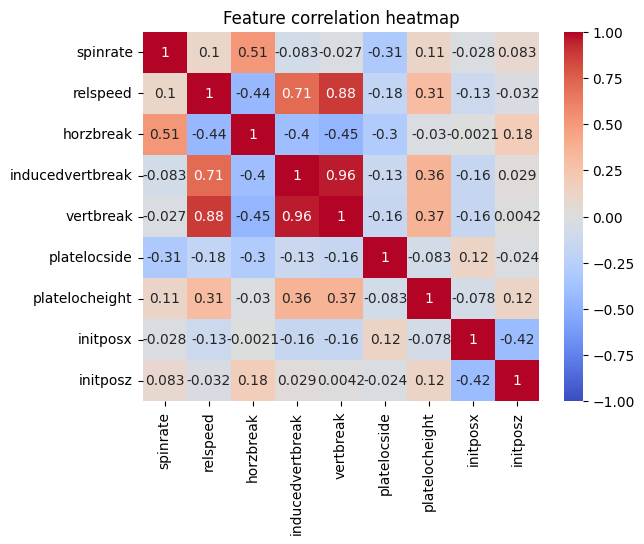

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_LR.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature correlation heatmap")
plt.show()


In [58]:
pred_probs_LR = gam_LR.predict_proba(X_test_LR)
pred_class_LR = gam_LR.predict(X_test_LR)

print("AUC:", roc_auc_score(y_test_LR, pred_probs_LR))
print("Accuracy:", accuracy_score(y_test_LR, pred_class_LR))

AUC: 0.6273562154709046
Accuracy: 0.8426173347036656


# GAM with different smoothing surfaces

In [73]:
pred_probs_RR_2 = gam_RR_2.predict_proba(X_test_RR_2)
pred_class_RR_2 = gam_RR_2.predict(X_test_RR_2)
print("AUC:", roc_auc_score(y_test_RR_2, pred_probs_RR_2))
print("Accuracy:", accuracy_score(y_test_RR_2, pred_class_RR_2))

AUC: 0.6263782858776654
Accuracy: 0.8299613313078305


# GAMs w Rocco's Recs

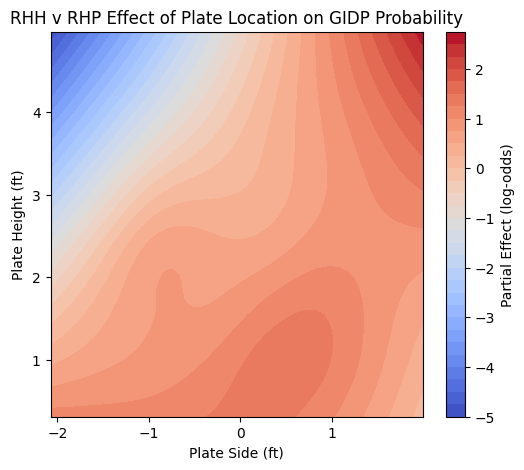

In [74]:
def create_zone_heatmap(gam, X_train, title_str='RHH v RHP'):
    '''
    Creates a heatmap to visualize the effect of plate location (side and height)
    on the probability of a GIDP occurring, based on the fitted GAM model.

    Params:
    gam_RR: Fitted LogisticGAM model
    X_train: Training feature set used for the model
    '''
    zone_idx = 4
    x_range = np.linspace(X_train[:, 4].min(), X_train[:, 4].max(), 50)  # plate side
    z_range = np.linspace(X_train[:, 5].min(), X_train[:, 5].max(), 50)  # plate height
    XX, ZZ = np.meshgrid(x_range, z_range)
    pdep = gam.partial_dependence(term=zone_idx, X=(XX, ZZ), meshgrid=True)
    plt.figure(figsize=(6, 5))
    plt.contourf(XX, ZZ, pdep, levels=30, cmap="coolwarm")
    plt.colorbar(label="Partial Effect (log-odds)")
    plt.xlabel("Plate Side (ft)")
    plt.ylabel("Plate Height (ft)")
    plt.title(f"{title_str} Effect of Plate Location on GIDP Probability")
    plt.show()

create_zone_heatmap(gam_RR_3, X_train_RR_3, title_str='RHH v RHP')

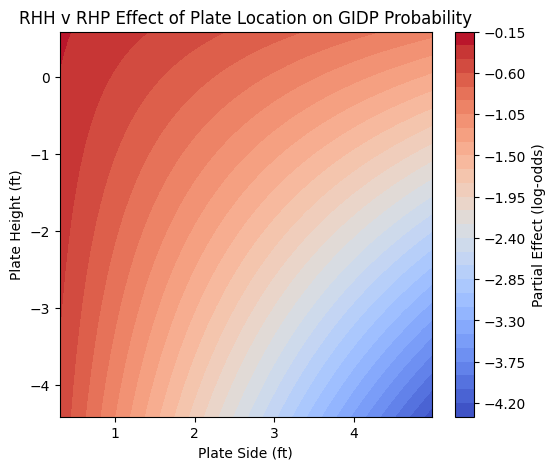

In [77]:
def create_rp_heatmap(gam, X_train, title_str='RHH v RHP'):
    '''
    Creates a heatmap to visualize the effect of plate location (side and height)
    on the probability of a GIDP occurring, based on the fitted GAM model.

    Params:
    gam_RR: Fitted LogisticGAM model
    X_train: Training feature set used for the model
    '''
    zone_idx = 5
    x_range = np.linspace(X_train[:, 5].min(), X_train[:, 5].max(), 50)  # plate side
    z_range = np.linspace(X_train[:, 6].min(), X_train[:, 6].max(), 50)  # plate height
    XX, ZZ = np.meshgrid(x_range, z_range)
    pdep = gam.partial_dependence(term=zone_idx, X=(XX, ZZ), meshgrid=True)
    plt.figure(figsize=(6, 5))
    plt.contourf(XX, ZZ, pdep, levels=30, cmap="coolwarm")
    plt.colorbar(label="Partial Effect (log-odds)")
    plt.xlabel("Plate Side (ft)")
    plt.ylabel("Plate Height (ft)")
    plt.title(f"{title_str} Effect of Plate Location on GIDP Probability")
    plt.show()

create_rp_heatmap(gam_RR_3, X_train_RR_3, title_str='RHH v RHP')

In [60]:
gam_RR_3.summary()


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     15.6464
Link Function:                        LogitLink Log Likelihood:                                 -3576.8277
Number of Samples:                         8000 AIC:                                             7184.9482
                                                AICc:                                            7185.0218
                                                UBRE:                                               2.8997
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0285
Feature Function                  Lam

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_14391/844585462.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_RR_3.summary()


# Refined GAMs:

## RHP v RHH

In [110]:
X_RR = RHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak',
                'platelocside', 'platelocheight', 'initposx', 'initposz']
                ]
Y_RR = RHP_RHH['GIDP_SweetSpot']

X_train_RR, X_test_RR, y_train_RR, y_test_RR = train_test_split(
    np.array(X_RR), np.array(Y_RR),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_RR)
)

# Grid search for best hyperparameters
gam_RR = LogisticGAM(
    s(0) + # Ind spline for spin rate
    s(1) + # Ind spine for release speed
    s(2) + # Ind spline for induced vertical break
    s(3) + # Ind spline for horizontal break
    te(4, 5) + # Tensor interaction for plate location with ind splines
    te(6, 7) # Tensor interaction for initial position with ind splines
    ).gridsearch(X_train_RR, y_train_RR)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:23 ETA:   0:03:54
 18% (2 of 11) |####                     | Elapsed Time: 0:00:37 ETA:   0:02:49
 27% (3 of 11) |######                   | Elapsed Time: 0:00:50 ETA:   0:02:14
 36% (4 of 11) |#########                | Elapsed Time: 0:01:02 ETA:   0:01:48
 45% (5 of 11) |###########              | Elapsed Time: 0:01:13 ETA:   0:01:28
 54% (6 of 11) |#############            | Elapsed Time: 0:01:25 ETA:   0:01:10
 63% (7 of 11) |###############          | Elapsed Time: 0:01:34 ETA:   0:00:53
 72% (8 of 11) |##################       | Elapsed Time: 0:01:42 ETA:   0:00:38
 81% (9 of 11) |####################     | Elapsed Time: 0:01:51 ETA:   0:00:24
 90% (10 of 11) |#####################   | Elapsed Time: 0:02:00 ETA:   0:00:12
100% (11 of 11) |########################| Elapsed Time: 0:02:09 Time:  0:02:09


In [123]:
# Trying individual lambdas
import random
# Generalized cross-validation to choose lambda
gam_RR_2 = LogisticGAM(
    s(0) + # Ind spline for spin rate
    s(1) + # Ind spine for release speed
    s(2) + # Ind spline for induced vertical break
    s(3) + # Ind spline for horizontal break
    te(4, 5) + # Tensor interaction for plate location with ind splines
    te(6, 7) # Tensor interaction for initial position with ind splines
    ).gridsearch(X_train_RR, y_train_RR, lam=np.exp(np.random.random((50, 4)) * 6 - 3))

ValueError: lam grid should have 8 columns, but found grid with 50 columns

In [118]:
gam_RR_2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    118.5482
Link Function:                        LogitLink Log Likelihood:                                 -51099.345
Number of Samples:                       115856 AIC:                                           102435.7864
                                                AICc:                                          102436.0355
                                                UBRE:                                                2.885
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0326
Feature Function                  Lam

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_14391/2031045699.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_RR_2.summary()


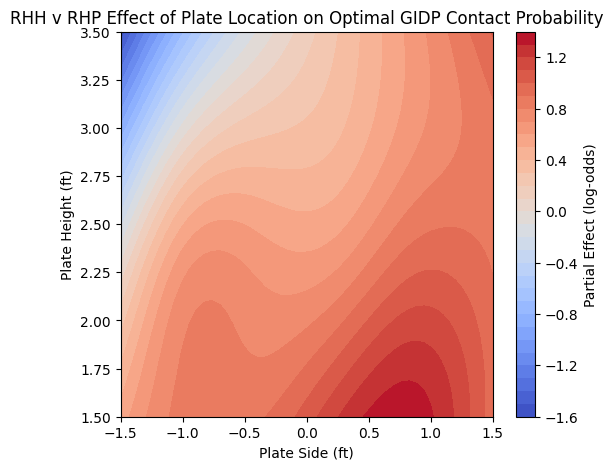

In [92]:
# Drawing the strikezone -- not just actual zone

def create_strikezone_heatmap(gam, X_train, title_str='RHH v RHP'):
    '''
    Creates a heatmap to visualize the effect of plate location (side and height)
    on the probability of a GIDP occurring, based on the fitted GAM model.

    Params:
    gam_RR: Fitted LogisticGAM model
    X_train: Training feature set used for the model
    '''
    zone_idx = 4
    x_range = np.linspace(-1.5, 1.5, 50)  # plate side
    z_range = np.linspace(1.5, 3.5, 50)  # plate height
    XX, ZZ = np.meshgrid(x_range, z_range)
    pdep = gam.partial_dependence(term=zone_idx, X=(XX, ZZ), meshgrid=True)
    plt.figure(figsize=(6, 5))
    plt.contourf(XX, ZZ, pdep, levels=30, cmap="coolwarm")
    plt.colorbar(label="Partial Effect (log-odds)")
    plt.xlabel("Plate Side (ft)")
    plt.ylabel("Plate Height (ft)")
    plt.title(f"{title_str} Effect of Plate Location on Optimal GIDP Contact Probability")
    plt.show()

create_strikezone_heatmap(gam_RR, X_train_RR, title_str='RHH v RHP')


## RHP v LHH

In [97]:
X_RL = RHP_LHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak',
                'platelocside', 'platelocheight', 'initposx', 'initposz']
                ]
Y_RL = RHP_LHH['GIDP_SweetSpot']

X_train_RL, X_test_RL, y_train_RL, y_test_RL = train_test_split(
    np.array(X_RL), np.array(Y_RL),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_RL)
)

# Grid search for best hyperparameters
gam_RL = LogisticGAM(
    s(0) + # Ind spline for spin rate
    s(1) + # Ind spine for release speed
    s(2) + # Ind spline for induced vertical break
    s(3) + # Ind spline for horizontal break
    te(4, 5) + # Tensor interaction for plate location with ind splines
    te(6, 7) # Tensor interaction for initial position with ind splines
    ).gridsearch(X_train_RL, y_train_RL)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:14 ETA:   0:02:22
 18% (2 of 11) |####                     | Elapsed Time: 0:00:25 ETA:   0:01:56
 27% (3 of 11) |######                   | Elapsed Time: 0:00:36 ETA:   0:01:36
 36% (4 of 11) |#########                | Elapsed Time: 0:00:45 ETA:   0:01:19
 45% (5 of 11) |###########              | Elapsed Time: 0:00:53 ETA:   0:01:04
 54% (6 of 11) |#############            | Elapsed Time: 0:01:01 ETA:   0:00:51
 63% (7 of 11) |###############          | Elapsed Time: 0:01:09 ETA:   0:00:39
 72% (8 of 11) |##################       | Elapsed Time: 0:01:16 ETA:   0:00:28
 81% (9 of 11) |####################     | Elapsed Time: 0:01:25 ETA:   0:00:19
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:33 ETA:   0:00:09
100% (11 of 11) |########################| Elapsed Time: 0:01:42 Time:  0:01:42


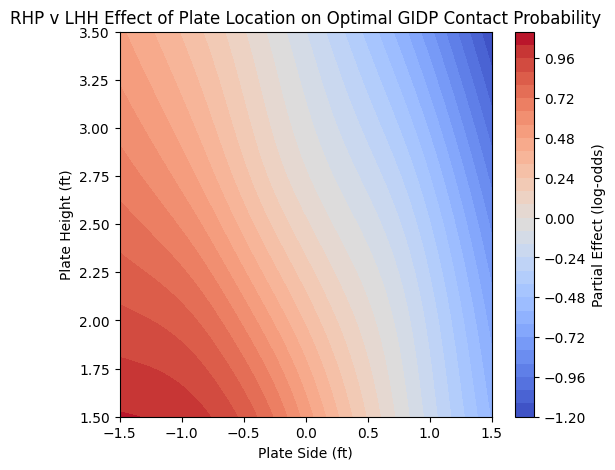

In [98]:
create_strikezone_heatmap(gam_RL, X_train_RL, title_str='RHP v LHH')

## LHP v RHH

In [95]:
X_LR = LHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak',
                'platelocside', 'platelocheight', 'initposx', 'initposz']
                ]
Y_LR = LHP_RHH['GIDP_SweetSpot']

X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
    np.array(X_LR), np.array(Y_LR),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_LR)
)

# Grid search for best hyperparameters
gam_LR = LogisticGAM(
    s(0) + # Ind spline for spin rate
    s(1) + # Ind spine for release speed
    s(2) + # Ind spline for induced vertical break
    s(3) + # Ind spline for horizontal break
    te(4, 5) + # Tensor interaction for plate location with ind splines
    te(6, 7) # Tensor interaction for initial position with ind splines
    ).gridsearch(X_train_LR, y_train_LR)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:12 ETA:   0:02:04
 18% (2 of 11) |####                     | Elapsed Time: 0:00:24 ETA:   0:01:52
 27% (3 of 11) |######                   | Elapsed Time: 0:00:34 ETA:   0:01:32
 36% (4 of 11) |#########                | Elapsed Time: 0:00:40 ETA:   0:01:11
 45% (5 of 11) |###########              | Elapsed Time: 0:00:46 ETA:   0:00:55
 54% (6 of 11) |#############            | Elapsed Time: 0:00:51 ETA:   0:00:42
 63% (7 of 11) |###############          | Elapsed Time: 0:00:58 ETA:   0:00:33
 72% (8 of 11) |##################       | Elapsed Time: 0:01:04 ETA:   0:00:24
 81% (9 of 11) |####################     | Elapsed Time: 0:01:10 ETA:   0:00:15
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:14 ETA:   0:00:07
100% (11 of 11) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


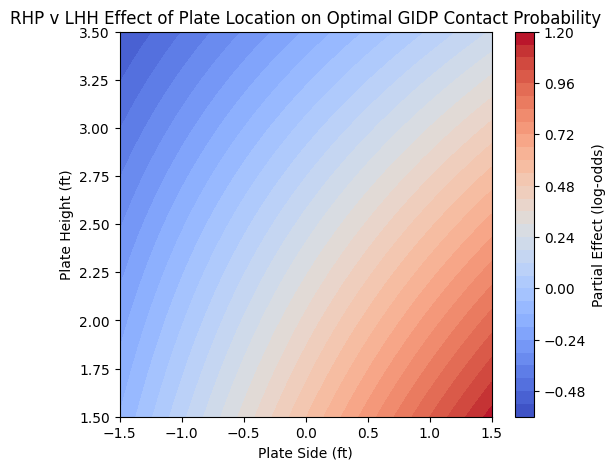

In [99]:
create_strikezone_heatmap(gam_LR, X_train_LR, title_str='RHP v LHH')

## LHP v LHH

In [100]:
X_LL = LHP_LHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak',
                'platelocside', 'platelocheight', 'initposx', 'initposz']
                ]
Y_LL = LHP_LHH['GIDP_SweetSpot']

X_train_LL, X_test_LL, y_train_LL, y_test_LL = train_test_split(
    np.array(X_LL), np.array(Y_LL),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_LL)
)

# Grid search for best hyperparameters
gam_LL = LogisticGAM(
    s(0) + # Ind spline for spin rate
    s(1) + # Ind spine for release speed
    s(2) + # Ind spline for induced vertical break
    s(3) + # Ind spline for horizontal break
    te(4, 5) + # Tensor interaction for plate location with ind splines
    te(6, 7) # Tensor interaction for initial position with ind splines
    ).gridsearch(X_train_LL, y_train_LL)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:04 ETA:   0:00:43
 18% (2 of 11) |####                     | Elapsed Time: 0:00:07 ETA:   0:00:34
 27% (3 of 11) |######                   | Elapsed Time: 0:00:10 ETA:   0:00:26
 36% (4 of 11) |#########                | Elapsed Time: 0:00:12 ETA:   0:00:21
 45% (5 of 11) |###########              | Elapsed Time: 0:00:15 ETA:   0:00:18
 54% (6 of 11) |#############            | Elapsed Time: 0:00:17 ETA:   0:00:14
 63% (7 of 11) |###############          | Elapsed Time: 0:00:19 ETA:   0:00:11
 72% (8 of 11) |##################       | Elapsed Time: 0:00:22 ETA:   0:00:08
 81% (9 of 11) |####################     | Elapsed Time: 0:00:24 ETA:   0:00:05
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:26 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


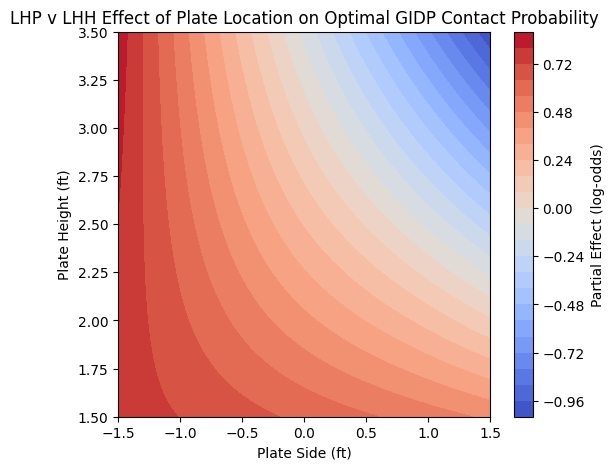

In [101]:
create_strikezone_heatmap(gam_LL, X_train_LL, title_str='LHP v LHH')

# Inference: Summaries, Plotting, Model Evalutation, etc.

## RHP v RHH

In [102]:
# Model evalutation metrics
pred_probs_RR = gam_RR.predict_proba(X_test_RR)
pred_class_RR = gam_RR.predict(X_test_RR)
print("AUC:", roc_auc_score(y_test_RR, pred_probs_RR))
print("Accuracy:", accuracy_score(y_test_RR, pred_class_RR))

AUC: 0.6254212201281208
Accuracy: 0.8299613313078305


In [103]:
# Model summary
gam_RR.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     73.6213
Link Function:                        LogitLink Log Likelihood:                                -51138.7916
Number of Samples:                       115856 AIC:                                           102424.8257
                                                AICc:                                          102424.9231
                                                UBRE:                                               2.8846
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0319
Feature Function                  Lam

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_14391/2320503136.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_RR.summary()


# Engineering Our Own Pitch Types

## Split by Handedness

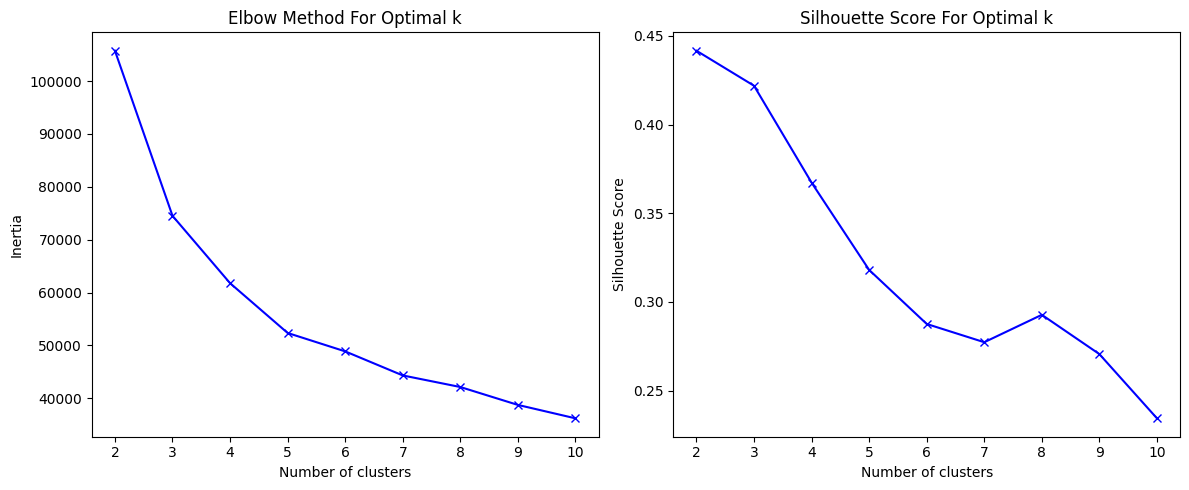

In [48]:

# Right Handed pitches
RHP_pitch_profiles = (pitches_total_sorted[pitches_total_sorted['pitcherthrows'] == 'R']
                      [['spinrate', 'relspeed', 'inducedvertbreak', 
                        'horzbreak']].dropna())
random_50k_idx = random.sample(range(len(RHP_pitch_profiles)), 50000)
RHP_pitch_profiles = RHP_pitch_profiles.iloc[random_50k_idx]
# Scale data
RHP_scaler = StandardScaler()
RHP_pitch_profiles_scaled = RHP_scaler.fit_transform(RHP_pitch_profiles)
# KMeans clustering

# Use elbow method and silhouette score to find optimal k
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RHP_pitch_profiles_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(RHP_pitch_profiles_scaled, kmeans.labels_))
# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

In [49]:
# Running kmeans: 
k = 5
kmeans_RHP = KMeans(n_clusters=k, n_init=50, random_state=42)
RHP_pitch_profiles['Cluster'] = kmeans_RHP.fit_predict(RHP_pitch_profiles_scaled)

In [50]:
# Cluster centers for RHP
print("RHP Cluster Centers:")
print(RHP_scaler.inverse_transform(kmeans_RHP.cluster_centers_))

RHP Cluster Centers:
[[2126.63343199   92.45913283    7.3824783    15.07174518]
 [2402.04023066   86.84952793    3.88668073   -4.10891043]
 [2609.07828116   80.99418225   -6.01031594  -11.28130074]
 [2317.49044257   94.6429478    15.96456629    7.02509479]
 [1527.68792293   85.76298621    4.17499614   12.03855396]]


In [55]:
# Apply clusters to our datasets
RHP_RHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(
    RHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))
RHP_LHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(
    RHP_LHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_59314/2846908076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHP_RHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(
/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_59314/2846908076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHP_LHH['Cluster'] = kmeans_RHP.predict(RHP_scaler.transform(


In [145]:
RHP_RHH['video_broadcast'].values[3]

'https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3dEdEUT09X0FBTUhWZ1lBVlFFQUMxWUxVd0FBVlFFSEFGaFdWVk1BQndNRVZRTUFBUU5TVlFKUw==.mp4'

## Left Handed Now

In [56]:
# Left handed pitches
LHP_pitch_profiles = (pitches_total_sorted[pitches_total_sorted['pitcherthrows'] == 'L']
                      [['spinrate', 'relspeed', 'inducedvertbreak', 
                        'horzbreak']].dropna())
random_50k_idx = random.sample(range(len(LHP_pitch_profiles)), 50000)
LHP_pitch_profiles = LHP_pitch_profiles.iloc[random_50k_idx]
# Scale data
LHP_scaler = StandardScaler()
LHP_pitch_profiles_scaled = LHP_scaler.fit_transform(LHP_pitch_profiles)
# KMeans clustering
k = 5
kmeans_LHP = KMeans(n_clusters=k, n_init=50, random_state=42)
LHP_pitch_profiles['Cluster'] = kmeans_LHP.fit_predict(LHP_pitch_profiles_scaled)
# Cluster centers for LHP
print("LHP Cluster Centers:")
print(LHP_scaler.inverse_transform(kmeans_LHP.cluster_centers_))

LHP Cluster Centers:
[[2266.7789867    93.35679967   16.15131466   -7.48532029]
 [2302.937668     85.49932073    3.86360337    3.42152646]
 [2104.63365405   91.42148833    8.01833578  -15.41711365]
 [2510.08917807   79.32116797   -5.67496653   10.66793805]
 [1620.38530646   83.72843836    5.93488467  -13.11390379]]


In [57]:
# Apply to our subsets
LHP_RHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(
    LHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))
LHP_LHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(
    LHP_LHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak']]
    ))

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_59314/3302102370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LHP_RHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(
/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_59314/3302102370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LHP_LHH['Cluster'] = kmeans_LHP.predict(LHP_scaler.transform(


In [81]:
LHP_RHH[LHP_RHH['pitchname_desc'] == 'Sinker']

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot,GIDP_SweetSpot_60,Cluster
106,2022/04/07/cinmlb-atlmlb-1,08:00.0,30,4,4,0,0,2,1,3,1,"Fried, Max",L,"Farmer, Kyle",R,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2274.470,95.06247,-7.167854,9.019536,-20.99168,-0.223374,2.862048,93.01332,-19.568790,-27.388610,1.006,50,6.063,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1,1,0
155,2022/04/07/cinmlb-atlmlb-1,08:00.0,43,1,6,0,0,0,0,3,1,"Fried, Max",L,"Stephenson, Tyler",R,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2047.933,92.91889,-9.756720,10.520210,-21.04558,0.345919,3.011450,99.86701,33.006690,0.253527,1.157,50,6.025,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0,2
602,2022/04/07/houmlb-anamlb-1,38:00.0,8,4,1,1,2,1,1,0,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2096.595,92.90878,-11.515430,5.122625,-26.44516,0.637365,1.679411,80.24135,-25.792980,-26.002420,0.990,50,5.847,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1,1,2
617,2022/04/07/houmlb-anamlb-1,38:00.0,12,4,2,1,2,1,0,0,0,"Valdez, Framber",L,"Duffy, Matt",R,D,Hit Into Play - No Out(s),single,Windup,SI,Sinker,2193.085,93.92500,-6.643946,8.010147,-22.99160,-0.244136,2.922022,85.40675,-9.609417,39.510410,0.908,50,5.985,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,0,0,0
683,2022/04/07/houmlb-anamlb-1,38:00.0,28,2,4,1,0,1,1,1,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),field_out,Unknown,SI,Sinker,2064.555,94.90443,-13.379630,5.918291,-24.48310,0.263612,1.694757,66.34743,-34.548680,-30.572800,1.031,50,5.868,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128689,2024/09/30/nynmlb-atlmlb-2,15:00.0,11,6,2,1,3,2,0,0,0,"Lucchesi, Joey",L,"Soler, Jorge",R,D,Hit Into Play - No Out(s),double,Unknown,SI,Sinker,2135.969,91.11298,-14.545690,5.463230,-27.43010,0.449357,2.970488,96.48756,29.983360,24.705370,2.372,50,5.672,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0,2
2128775,2024/09/30/nynmlb-atlmlb-2,15:00.0,29,6,4,1,3,2,1,0,1,"Lucchesi, Joey",L,"Murphy, Sean",R,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2020.722,89.76155,-13.731320,5.027273,-28.91120,0.322145,2.040437,91.33065,33.264850,29.211460,2.382,50,5.688,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0,2
2128781,2024/09/30/nynmlb-atlmlb-2,15:00.0,30,6,4,1,2,2,2,0,1,"Lucchesi, Joey",L,"Arcia, Orlando",R,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2146.077,90.73888,-14.799980,6.631030,-26.59507,0.426047,2.085309,105.65250,-15.881970,19.433210,2.505,50,5.454,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0,2
2128806,2024/09/30/nynmlb-atlmlb-2,15:00.0,37,2,5,1,1,0,1,0,1,"Lucchesi, Joey",L,"Albies, Ozzie",R,X,Hit Into Play - Out(s),field_out,Unknown,SI,Sinker,2098.688,88.49702,-15.203220,6.911229,-28.05096,-0.367012,1.130504,102.86400,-7.391477,-34.198620,2.285,50,5.634,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0T

In [58]:
# Investigating specific pitch clusters
for i in range(5):
    cluster = RHP_pitch_profiles[RHP_pitch_profiles['Cluster'] == i]
    print(f"RHP Cluster {i}:")
    print(cluster.describe())
    print("\n")
for j in range(5):
    cluster = LHP_pitch_profiles[LHP_pitch_profiles['Cluster'] == j]
    print(f"LHP Cluster {j}:")
    print(cluster.describe())
    print("\n")

RHP Cluster 0:
          spinrate     relspeed  inducedvertbreak    horzbreak  Cluster
count  9322.000000  9322.000000       9322.000000  9322.000000   9322.0
mean   2127.278284    92.472213          7.395975    15.066934      0.0
std     165.068988     3.522041          4.175835     3.114687      0.0
min    1460.247000    79.231270        -13.837160    -0.913327      0.0
25%    2018.331750    90.510900          4.854866    13.390178      0.0
50%    2126.235000    92.862405          7.821767    15.489020      0.0
75%    2234.404750    94.902947         10.417675    17.161968      0.0
max    3295.563000   102.122700         23.175560    46.444960      0.0


RHP Cluster 1:
           spinrate      relspeed  inducedvertbreak     horzbreak  Cluster
count  11091.000000  11091.000000      11091.000000  11091.000000  11091.0
mean    2402.065675     86.848306          3.884389     -4.110598      1.0
std      212.905314      3.005780          4.297988      3.990433      0.0
min     1508.747000 

In [60]:
# See what pitch types are associated with each cluster
for i in range(5):
    print(f"RHP Cluster {i} Pitch Types:")
    print(RHP_RHH[RHP_RHH['Cluster'] == i]['pitchname_desc'].value_counts())
    print("\n")

RHP Cluster 0 Pitch Types:
pitchname_desc
Sinker          29196
Four-seam FB     2771
Changeup         2056
Splitter          199
Slider            109
Cutter             73
Two-seam FB         3
Screwball           1
Name: count, dtype: int64


RHP Cluster 1 Pitch Types:
pitchname_desc
Slider           25077
Cutter            9364
Sweeper           1726
Curveball          711
Four-seam FB       327
Changeup           319
Knuckle Curve      282
Sinker             105
Splitter            30
Slurve              27
Screwball            8
Forkball             2
Slow Curve           1
Name: count, dtype: int64


RHP Cluster 2 Pitch Types:
pitchname_desc
Slider           8754
Curveball        6758
Sweeper          4629
Knuckle Curve    1689
Slurve            323
Cutter            132
Sinker             48
Four-seam FB       42
Changeup           10
Slow Curve          5
Splitter            1
Screwball           1
Name: count, dtype: int64


RHP Cluster 3 Pitch Types:
pitchname_desc
Four-seam

In [62]:
bip_df

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot,GIDP_SweetSpot_60
10,2022/04/07/cinmlb-atlmlb-1,08:00.0,3,3,1,0,2,0,2,0,0,"Fried, Max",L,"Pham, Tommy",R,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2176.828,95.56983,2.139670,11.539330,-18.21491,-1.113873,2.525816,55.31276,-42.227200,-0.448136,0.882,50,6.069,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
19,2022/04/07/cinmlb-atlmlb-1,08:00.0,6,3,1,1,1,1,2,0,0,"Mahle, Tyler",R,"Riley, Austin",R,D,Hit Into Play - No Out(s),single,Windup,FF,Four-seam FB,2360.456,93.33314,9.302727,16.755390,-14.57288,-0.499844,2.849501,91.72955,-0.069351,12.199050,-2.658,50,5.441,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
21,2022/04/07/cinmlb-atlmlb-1,08:00.0,7,2,1,1,0,1,2,0,0,"Mahle, Tyler",R,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Stretch,SL,Slider,2663.398,84.64002,-4.788012,1.895149,-35.77917,-0.035831,2.105335,100.97140,36.611920,-17.393650,-2.744,50,5.532,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
31,2022/04/07/cinmlb-atlmlb-1,08:00.0,10,3,2,0,1,1,1,0,0,"Fried, Max",L,"Senzel, Nick",R,D,Hit Into Play - No Out(s),single,Stretch,SL,Slider,2307.948,89.99753,4.627371,3.820850,-29.52298,0.035648,2.418733,98.19635,8.123025,-3.759704,1.352,50,6.026,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
34,2022/04/07/cinmlb-atlmlb-1,08:00.0,11,3,2,0,2,0,1,0,0,"Fried, Max",L,"Moustakas, Mike",L,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2167.002,95.81812,0.946951,14.476550,-15.27192,-0.957702,2.325284,69.13850,64.647930,-1.996992,0.921,50,6.013,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128893,2024/09/30/nynmlb-atlmlb-2,15:00.0,61,3,8,1,1,1,1,0,3,"Ottavino, Adam",R,"Laureano, Ramon",R,X,Hit Into Play - Out(s),field_out,Stretch,ST,Sweeper,2742.300,78.96707,-16.568070,4.549791,-39.20681,0.113148,2.521548,49.44353,-2.311208,26.003910,-2.834,50,5.365,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0
2128894,2024/09/30/nynmlb-atlmlb-2,15:00.0,62,1,8,1,0,0,2,0,3,"Ottavino, Adam",R,"Urshela, Giovanny",R,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2274.384,90.91328,9.308056,13.595360,-19.27886,-0.411438,2.685040,90.87400,64.098850,-12.173490,-2.318,50,5.451,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0
2128898,2024/09/30/nynmlb-atlmlb-2,15:00.0,63,4,9,0,1,2,0,0,3,"Iglesias, Raisel",R,"Iglesias, Jose",R,D,Hit Into Play - No Out(s),single,Windup,CH,Changeup,2010.299,89.93185,15.594400,6.404220,-27.34787,0.350546,0.988079,71.68848,3.357973,-25.181620,-0.978,50,5.286,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1,1
2128901,2024/09/30/nynmlb-atlmlb-2,15:00.0,64,3,9,0,0,2,0,0,3,"Iglesias, Raisel",R,"Nimmo, Brandon",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,CH,Changeup,2117.316,90.45467,15.035450,6.675668,-26.57427,-0.117966,2.273107,100.57000,-6.433260,22.419940,-1.167,50,5.374,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0


In [66]:
len(bip_df[bip_df['pitcherthrows'] == 'R']) / len(bip_df[bip_df['pitcherthrows'] == 'L'])

2.7003885567031065

In [64]:
len(bip_df[bip_df['pitcherthrows'] == 'L'])

99342

# Describing Pitch Clusters:

## RHP Cluster 0:
- Mean Speed: 92.472213 
- Mean IVB: 7.395975
- Mean HB: 15.06693
- Mean Spinrate: 2127.278284
- Sinker/2seamer/pronator fastball

## RHP Cluster 1:
- Mean Speed: 86.848306
- Mean IVB: 3.884389
- Mean HB: -4.110598
- Mean Spinrate: 2402.065675
- Description: Slider/cutter profile

## RHP Cluster 2:

In [61]:
# See what pitch types are associated with each cluster 

for i in range(5):
    print(f"LHP Cluster {i} Pitch Types:")
    print(LHP_LHH[LHP_LHH['Cluster'] == i]['pitchname_desc'].value_counts())
    print("\n")


LHP Cluster 0 Pitch Types:
pitchname_desc
Four-seam FB    6175
Sinker           803
Cutter           122
Slider            32
Changeup           8
Name: count, dtype: int64


LHP Cluster 1 Pitch Types:
pitchname_desc
Slider           4273
Cutter           1509
Sweeper           304
Curveball         293
Four-seam FB      158
Knuckle Curve     111
Slurve             11
Changeup           10
Sinker              9
Splitter            4
Name: count, dtype: int64


LHP Cluster 2 Pitch Types:
pitchname_desc
Sinker          6025
Four-seam FB    1008
Changeup         204
Cutter            25
Slider             5
Splitter           1
Name: count, dtype: int64


LHP Cluster 3 Pitch Types:
pitchname_desc
Slider           1699
Curveball        1456
Sweeper           816
Knuckle Curve     176
Slurve             85
Cutter             62
Name: count, dtype: int64


LHP Cluster 4 Pitch Types:
pitchname_desc
Changeup         649
Sinker           176
Slider            49
Splitter          43
Four-seam F

In [162]:
# Converting to CSVs for export to R
RHP_RHH.to_csv('RHP_RHH_GIDP_ByPitchCluster.csv', index=False)
RHP_LHH.to_csv('RHP_LHH_GIDP_ByPitchCluster.csv', index=False)
LHP_RHH.to_csv('LHP_RHH_GIDP_ByPitchCluster.csv', index=False)
LHP_LHH.to_csv('LHP_LHH_GIDP_ByPitchCluster.csv', index=False)

In [163]:
RHP_RHH

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot,Cluster
19,2022/04/07/cinmlb-atlmlb-1,08:00.0,6,3,1,1,1,1,2,0,0,"Mahle, Tyler",R,"Riley, Austin",R,D,Hit Into Play - No Out(s),single,Windup,FF,Four-seam FB,2360.456,93.33314,9.302727,16.755390,-14.57288,-0.499844,2.849501,91.72955,-0.069351,12.199050,-2.658,50,5.441,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,1
21,2022/04/07/cinmlb-atlmlb-1,08:00.0,7,2,1,1,0,1,2,0,0,"Mahle, Tyler",R,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Stretch,SL,Slider,2663.398,84.64002,-4.788012,1.895149,-35.77917,-0.035831,2.105335,100.97140,36.611920,-17.393650,-2.744,50,5.532,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
50,2022/04/07/cinmlb-atlmlb-1,08:00.0,16,2,2,1,0,1,2,1,0,"Mahle, Tyler",R,"d'Arnaud, Travis",R,X,Hit Into Play - Out(s),field_out,Windup,FF,Four-seam FB,2290.282,93.24728,7.111188,18.027850,-13.39577,-0.934446,2.899742,99.55784,35.391800,-20.757010,-2.670,50,5.460,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,1
93,2022/04/07/cinmlb-atlmlb-1,08:00.0,27,6,3,1,3,2,2,3,0,"Mahle, Tyler",R,"Riley, Austin",R,E,Hit Into Play - Run(s),single,Stretch,FS,Splitter,2049.751,88.71649,14.846860,10.787360,-24.06497,-0.415476,2.766921,98.12903,-7.397658,-45.254290,-2.567,50,5.536,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,3
98,2022/04/07/cinmlb-atlmlb-1,08:00.0,28,5,3,1,2,2,2,3,1,"Mahle, Tyler",R,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Stretch,SL,Slider,2726.340,86.27881,-4.915974,-0.871638,-37.39549,0.343936,1.412707,104.49260,5.529478,0.132835,-2.640,50,5.622,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128886,2024/09/30/nynmlb-atlmlb-2,15:00.0,59,3,8,0,2,0,2,0,3,"Jimenez, Joe",R,"Acuna, Luisangel",R,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2308.199,93.99814,6.471640,15.428630,-15.52162,0.994524,2.453676,77.57632,-3.701298,11.608980,-2.093,50,5.453,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,1
2128893,2024/09/30/nynmlb-atlmlb-2,15:00.0,61,3,8,1,1,1,1,0,3,"Ottavino, Adam",R,"Laureano, Ramon",R,X,Hit Into Play - Out(s),field_out,Stretch,ST,Sweeper,2742.300,78.96707,-16.568070,4.549791,-39.20681,0.113148,2.521548,49.44353,-2.311208,26.003910,-2.834,50,5.365,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,4
2128894,2024/09/30/nynmlb-atlmlb-2,15:00.0,62,1,8,1,0,0,2,0,3,"Ottavino, Adam",R,"Urshela, Giovanny",R,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2274.384,90.91328,9.308056,13.595360,-19.27886,-0.411438,2.685040,90.87400,64.098850,-12.173490,-2.318,50,5.451,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,1
2128898,2024/09/30/nynmlb-atlmlb-2,15:00.0,63,4,9,0,1,2,0,0,3,"Iglesias, Raisel",R,"Iglesias, Jose",R,D,Hit Into Play - No Out(s),single,Windup,CH,Changeup,2010.299,89.93185,15.594400,6.404220,-27.34787,0.350546,0.988079,71.68848,3.357973,-25.181620,-0.978,50,5.286,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1,3


In [164]:
RHP_RHH["Cluster"].values[1]

np.int32(0)

In [170]:
RHP_RHH[RHP_RHH["Cluster"] == 0]

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot,Cluster
21,2022/04/07/cinmlb-atlmlb-1,08:00.0,7,2,1,1,0,1,2,0,0,"Mahle, Tyler",R,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Stretch,SL,Slider,2663.398,84.64002,-4.788012,1.895149,-35.77917,-0.035831,2.105335,100.97140,36.611920,-17.393650,-2.744,50,5.532,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
98,2022/04/07/cinmlb-atlmlb-1,08:00.0,28,5,3,1,2,2,2,3,1,"Mahle, Tyler",R,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Stretch,SL,Slider,2726.340,86.27881,-4.915974,-0.871638,-37.39549,0.343936,1.412707,104.49260,5.529478,0.132835,-2.640,50,5.622,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,0,0
303,2022/04/07/clemlb-kcamlb-1,10:00.0,2,2,1,0,0,1,0,0,0,"Greinke, Zack",R,"Rosario, Amed",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SL,Slider,2182.046,84.92921,-4.482286,4.856304,-32.65087,0.235638,1.935225,98.10506,-7.327979,2.281181,-1.132,50,6.100,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1,0
309,2022/04/07/clemlb-kcamlb-1,10:00.0,4,3,1,1,0,2,0,0,0,"Bieber, Shane",R,"Merrifield, Whit",R,X,Hit Into Play - Out(s),field_out,Windup,KC,Knuckle Curve,1908.673,81.72587,-2.354240,-6.536314,-47.06068,0.034318,1.014507,81.47044,-20.048600,-21.574450,-1.008,50,5.668,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1,0
311,2022/04/07/clemlb-kcamlb-1,10:00.0,5,2,1,1,0,1,1,0,0,"Bieber, Shane",R,"Witt Jr, Bobby",R,X,Hit Into Play - Out(s),field_out,Windup,SL,Slider,2464.315,84.00928,-1.955413,0.060150,-37.95393,0.741102,3.021039,93.39116,34.891930,8.952760,-0.888,50,5.790,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128636,2024/09/30/nynmlb-atlmlb-1,10:00.0,80,7,9,1,3,2,1,8,7,"Diaz, Edwin",R,"White, Eli",R,D,Hit Into Play - No Out(s),single,Stretch,SL,Slider,2313.773,90.35955,-2.186809,5.593066,-27.61779,0.528748,1.732387,71.97697,20.886600,0.160293,-1.904,50,5.016,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,0,0
2128782,2024/09/30/nynmlb-atlmlb-2,15:00.0,31,1,5,0,0,0,0,0,1,"Holmes, Grant",R,"Alonso, Peter",R,D,Hit Into Play - No Out(s),single,Stretch,SL,Slider,2699.704,85.24258,-2.862460,0.393588,-37.01640,0.490707,2.146327,74.00455,21.688910,15.349260,-2.134,50,5.846,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0
2128803,2024/09/30/nynmlb-atlmlb-2,15:00.0,35,5,5,0,1,2,2,0,1,"Hernandez, Daysbel",R,"Torrens, Luis",R,X,Hit Into Play - Out(s),force_out,Stretch,SL,Slider,2783.261,87.94922,-3.970642,1.014536,-33.67555,0.616248,2.248824,76.94846,-30.813210,-44.944920,-0.942,50,5.755,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0
2128853,2024/09/30/nynmlb-atlmlb-2,15:00.0,50,6,7,0,2,2,2,0,1,"Lopez, Reynaldo",R,"Bader, Harrison",R,X,Hit Into Play - Out(s),field_out,Stretch,SL,Slider,2334.739,87.01099,-6.891970,-1.711858,-37.56133,0.287258,1.604255,79.08215,28.702920,-1.766185,-1.652,50,5.546,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,0,0


In [2]:
27+24

51